<a href="https://colab.research.google.com/github/Shahrzad-Mahboubi/Beale-Function-optimization/blob/main/NAG_Beale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the library
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation

In [2]:
#Beale function
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [3]:
def gradients(x, y):
  """Gradient of Beale function.

  Args:
    x: x-dimension of inputs
    y: y-dimension of inputs

  Returns:
    grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
      dx: gradient of Beale function with respect to x-dimension of inputs
      dy: gradient of Beale function with respect to y-dimension of inputs
  """
  dx = 2. * ( (1.5 - x + x * y) * (y - 1) + \
                (2.25 - x + x * y**2) * (y**2 - 1) + \
                (2.625 - x + x * y**3) * (y**3 - 1) )
  dy = 2. * ( (1.5 - x + x * y) * x + \
              (2.25 - x + x * y**2) * 2. * x * y + \
              (2.625 - x + x * y**3) * 3. * x * y**2 )
  grads = np.array([dx, dy])
  return grads

In [4]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [3.  0.5]
minima (2x1 column vector shape):
[[3. ]
 [0.5]]


In [5]:
# putting together our points to plot in a 3D plot
number_of_points = 350
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

# Set the maximum of Z-axis
z_max = 900

# Mask out of display range
z_mask_grid = np.ma.masked_where(z >= z_max, z)

# Get the logarithmic minimum/maximum value
z_log10_min = np.floor(np.log10(z.min()) - 1.0)
z_log10_max = np.ceil(np.log10(z.max()) + 1.0)

# Get the logarithmic minimum/maximum value
lev_log10 = np.linspace(z_log10_min, z_log10_max, num=50)[25:40]
levs = np.power(10, lev_log10)

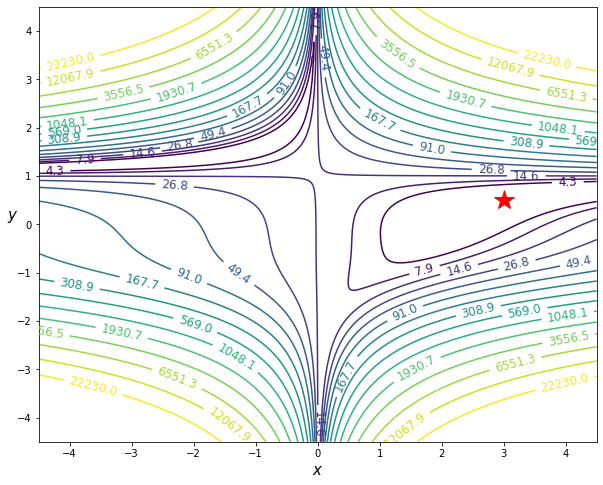

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

#contourSet = ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
contourSet = plt.contour(x_mesh, y_mesh, z, 
                  norm=LogNorm(), levels=levs) # Contour Plot
ax.plot(*minima, 'r*', markersize=20)
ax.clabel(contourSet, fontsize=12, fmt="%.1f")
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$', fontsize=15, rotation = 0)

#ax.set_xlim((x_min, x_max))
#ax.set_ylim((y_min, y_max))

plt.show()

In [7]:
class NesterovMomentumOptimizer():
  def __init__(self, function, gradients, x_init=None, y_init=None, learning_rate=0.01, momentum=0.9):
    self.f = function
    self.g = gradients
    scale = 3.0
    self.vars = np.zeros([2])
    if x_init is not None:
      self.vars[0] = x_init
    else:
      self.vars[0] = np.random.uniform(low=-scale, high=scale)
      print("x_init: {:.3f}".format(self.vars[0]))
    if y_init is not None:
      self.vars[1] = y_init
    else:
      self.vars[1] = np.random.uniform(low=-scale, high=scale)
    print("x_init: {:.3f}".format(self.vars[0]))
    print("y_init: {:.3f}".format(self.vars[1]))
    
    self.lr = learning_rate
    self.momentum = momentum
    self.velocity = np.zeros([2])
    
    # for accumulation of loss and path (w, b)
    self.z_history = []
    self.x_history = []
    self.y_history = []
  
  
  def func(self, variables):
    """Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      z: Beale function value at (x, y)
    """
    x, y = variables
    z = self.f(x, y)
    return z
  
  def gradients(self, variables):
    """Gradient of Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
        dx: gradient of Beale function with respect to x-dimension of inputs
        dy: gradient of Beale function with respect to y-dimension of inputs
    """
    x, y = variables
    grads = self.g(x, y)
    return grads
      
  def weights_update(self, grads):
    """Weights update using Nesterov Momentum.
    
      v' = gamma * v - lr * grads
      w' = w + v
    """
    self.velocity = self.momentum * self.velocity - self.lr * grads
    self.vars = self.vars + self.velocity
    
  def history_update(self, z, x, y):
    """Accumulate all interesting variables
    """
    self.z_history.append(z)
    self.x_history.append(x)
    self.y_history.append(y)
    
    
  def train(self, max_steps):
    pre_z = 0.0
    print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, self.func(self.vars), self.x, self.y))
    
    file = open('nesterov.momentum.txt', 'w')
    file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
    
    for step in range(max_steps):
      self.z = self.func(self.vars)
      self.history_update(self.z, self.x, self.y)

      x_ahead = self.x + self.momentum * self.v_x
      y_ahead = self.y + self.momentum * self.v_y
      
      self.grads = self.gradients([x_ahead, y_ahead])
      self.weights_update(self.grads)
      file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
      
      if (step+1) % 100 == 0:
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y, self.dx, self.dy))
        
      if np.abs(pre_z - self.z) < 1e-7:
        self.step = step+1
        print("Enough convergence")
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(self.step, self.func(self.vars), self.x, self.y))
        self.z = self.func(self.vars)
        self.history_update(self.z, self.x, self.y)
        break
        
      pre_z = self.z
    file.close()

    self.x_history = np.array(self.x_history)
    self.y_history = np.array(self.y_history)
    self.path = np.concatenate((np.expand_dims(self.x_history, 1), np.expand_dims(self.y_history, 1)), axis=1).T
    
    
  @property
  def x(self):
    return self.vars[0]
  
  @property
  def y(self):
    return self.vars[1]
  
  @property
  def dx(self):
    return self.grads[0]
  
  @property
  def dy(self):
    return self.grads[1]
  
  @property
  def v_x(self):
    return self.velocity[0]
  
  @property
  def v_y(self):
    return self.velocity[1]

In [8]:
opt = NesterovMomentumOptimizer(f, gradients, x_init=0.7, y_init=1.4, learning_rate=0.01, momentum=0.9)

x_init: 0.700
y_init: 1.400


In [9]:
%time
opt.train(1000)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
steps: 0  z: 26.496662  x: 0.70000  y: 1.40000
steps: 100  z: 0.013471  x: 3.34740  y: 0.57491  dx: 0.06233  dy: 0.01213
steps: 200  z: 0.000029  x: 3.01345  y: 0.50334  dx: 0.00398  dy: 0.00099
Enough convergence
steps: 236  z: 0.000001  x: 3.00219  y: 0.50054


In [10]:
print("Global minima")
print("x*: {:.2f}  y*: {:.2f}".format(minima[0], minima[1]))
print("Solution using the gradient descent")
print("x: {:.4f}  y: {:.4f}".format(opt.x, opt.y))

Global minima
x*: 3.00  y*: 0.50
Solution using the gradient descent
x: 3.0022  y: 0.5005


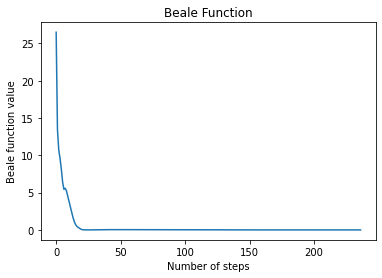

In [11]:
#Plot the Beale function
plt.title('Beale Function')
plt.xlabel('Number of steps')
plt.ylabel('Beale function value')
plt.plot(opt.z_history)
plt.show()

In [12]:
# putting together our points to plot in a 3D plot
number_of_points = 650
margin = 5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

# Set the maximum of Z-axis
z_max = 900

# Mask out of display range
z_mask_grid = np.ma.masked_where(z >= z_max, z)

# Get the logarithmic minimum/maximum value
z_log10_min = np.floor(np.log10(z.min()) - 1.0)
z_log10_max = np.ceil(np.log10(z.max()) + 1.0)

# Get the logarithmic minimum/maximum value
lev_log10 = np.linspace(z_log10_min, z_log10_max, num=50)[25:40]
levs = np.power(10, lev_log10)

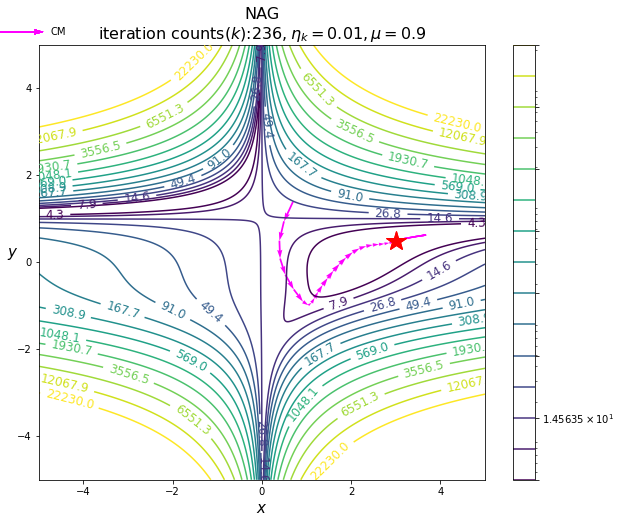

In [13]:
path = opt.path
fig, ax = plt.subplots(figsize=(10, 8))

#contourSet = ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet) # 等高線
ax.plot(*minima, 'r*', markersize=20)
contourSet = plt.contour(x_mesh, y_mesh, z, 
                  norm=LogNorm(), levels=levs) # Contour Plot
ax.plot(*minima, 'r*', markersize=20)
q = ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='magenta')

# 凡例
ax.quiverkey(q, X=0.01, Y=1.03, U=50, label='CM', labelpos='E',
             fontproperties={'size': 10})
plt.colorbar(contourSet)
ax.set_title("NAG"+ "\niteration counts($k$):" + str(opt.step)+"$,\\eta_k=$" + str(opt.lr)+"$,\\mu=$" + str(opt.momentum), fontsize=16) # タイトル
ax.clabel(contourSet, fontsize=12, fmt="%.1f")
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$', fontsize=15, rotation = 0)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
plt.savefig('./NAG.png')
plt.show()